In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

import pylib.conv_widget as cw
from pylib.tensorboardcmd import tensorboard_cmd

/opt/conda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/conv_widget.py -->
<!-- requirement: images/conv_movie.gif -->
<!-- requirement: images/portal-v.png -->
<!-- requirement: images/portal-h.png -->
<!-- requirement: images/conv_weights.png -->
<!-- requirement: images/conv_layer.png -->
<!-- requirement: images/CNN_schematic.png -->

# Convolutional Neural Networks

In the previous exercise, we flattened the MNIST images into vectors before feeding them into our model. Doing so, however, destroys information about shapes that are present in clusters of neighboring pixels. We can preserve this two dimensional information by using Convolutional Neural Networks (CNNs). 

CNNs are inspired by the [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex), which is responsible for image processing in animals. Neurons in the visual cortex fire in response to stimuli that activate small sub-regions of an animal's visual field. We can therefore think of these neurons as filters that detect patterns across the animal's visual field. 

We will train a CNN to find a set of filters that can detect repeated shapes in MNIST images. Convolving the image with a filter produces another image with highlighted features called a feature map. 

## Convolutions

A convolution is a mathematical operation that is performed on two functions. For continuous functions, it is defined as:

$$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t-\tau) d\tau $$

For discrete functions, it is:

$$ (f * g)(t) = \sum_{m=-\infty}^{\infty} f[m] g[n-m] $$

A function that is a convolution of two other functions can be thought of as the area between the two original functions as one function is translated. 

![convolution](images/conv_movie.gif)

### Convolving images and filters

Play around with the widget below, which demonstrates the process of convolving a 7x7 pixel image with a 3x3 pixel filter. At each iteration, the value of one pixel in the image (denoted by the red square) is replaced by the average of the pixel values within the 3x3 filter. In convolutional neural networks, a weight is assigned to each pixel in the filter, and consequently, the "red pixel" is replaced by weighted sum of the surrounded pixels. 

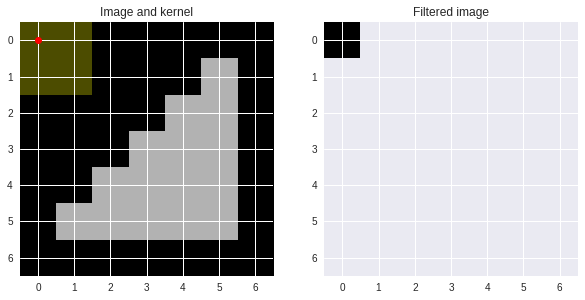

In [4]:
image = np.zeros((7, 7), dtype=float)
for i in xrange(1, 6):
    for j in xrange(6-i, 6):
        image[i][j] = 1

img_filter = np.ones((3, 3), dtype=float)
img_filter /= img_filter.size

titles = ('Image and kernel', 'Filtered image')
convwidget = cw.ConvWidget()
convwidget.interactive_convolution_demo(image, img_filter, vmax=1, titles=titles)

#### Strides

In the interactive widget, we perform the convolution at each pixel. However, we can choose to skip pixels. In TensorFlow, we can set the number of pixels our filter moves at each step, or the **stride**. How does the stride effect the dimension of the filtered image? Why would we want to change the stride?

In TensorFlow's `conv2d` function, we set the stride with `strides=[batch, stride_width, stride_height, channels]`. For the MNIST dataset, `strides=[1, k, k, 1]`. Since we are dealing with grayscale images, the number of channels is 1. If we had colored images, this value would be set to 3 (corresponding red, green, and blue values). 

#### Padding

Notice how the filter extends past the edge of the image while performing convolutions on some pixels. To deal with these edge cases, we typically **pad** the image or add more pixels to the perimeter of the image. This process ensures that the dimensions of the input image are the same as the dimensions of the output image. In the case of the MNIST dataset, the image is padded with zeros (or white space). When might we run into problems when padding images?

### Example: Applying a simple edge filter on a handwritten digit

The magic behind the convolutional neural network lies in the fact that each filter learns to recognize certain patterns repeated throughout images. To build our intuition for why this is the case, we will consider two very simple filters $(1,-1)$ and $(1,-1)^T$ applied to an image consisting of only black and white pixels (with values of 1 or 0). The image consists of a black, horizontal line connected to a black, vertical line and roughly resembles a "7." See the cell below. We see from the two resulting convolved images that the filters picked out vertical and horizontal edges, respectively. 

In [5]:
from scipy import signal as sg
ex_image = [[0, 0, 0, 0, 0],
            [1, 1, 1, 1, 0], # <---horizontal line of ones
            [0, 0, 0, 1, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 1, 0]]
                    # ^ vertical line of ones

print(sg.convolve(ex_image, [[1, -1]], "same")) #vertical edge
print(sg.convolve(ex_image, [[1], [-1]], "same")) #horizontal edge


[[ 0  0  0  0  0]
 [ 1  0  0  0 -1]
 [ 0  0  0  1 -1]
 [ 0  0  0  1 -1]
 [ 0  0  0  1 -1]]
[[ 0  0  0  0  0]
 [ 1  1  1  1  0]
 [-1 -1 -1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


If we apply the vertical and horizontal edge filters a handwritten 7, we get the following feature maps:
<table>
    <tr>
        <td> <img src="files/images/portal-v.png" style="width: 250px;"/> </td>
        <td> <img src="files/images/portal-h.png" style="width: 250px;"/> </td>
    </tr>
</table>

## Convolutional neural networks

Convolutional neural networks are comprised of a series of convolutional and max pooling layers, followed by a fully connected layer. Each of these will be explained in detail below. Let's first start off by repeating some of the steps we did in the previous notebook. 

In [6]:
reset_tf()

# Load data
data = input_data.read_data_sets('/tmp/data/', one_hot=True)

# Get class (number) for test data
data.test.cls = np.argmax(data.test.labels, axis=1)

# Set path to summary logs
now = datetime.now()
logs_path = now.strftime("%Y%m%d-%H%M%S") + '/summaries'

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now let's set our model parameters and define our placeholder variables. This step is very similar to the one we did in the previous notebook, but now we assign the number of channels to `n_channels` and the filter size to `filt_size`. For the sake of simplicity, we will not use dropout in this model. 

In [7]:
# Model parameters
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 50
num_iterations = 400 #1500
display_step = 100

# Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional layers

The purpose of the convolutional layer is to extract features from images. In this layer, a set of filters are convolved with some input to produce activation or feature maps. Then, the ReLU operation is applied to each pixel in the feature maps, converting negative pixel values to zero. During the training process, the CNN learns which filters activate when a certain features are present. 

In the example below, we choose 16 filters and a stride of 1. 


In [8]:
x_reshape = tf.reshape(x, shape=[-1, img_size, img_size, 1])
out_conv = tf.layers.conv2d(x_reshape, 16, filt_size, padding='same', activation=tf.nn.relu, name="convolution")

This will add the kernels to the TensorBoard output, so that we can visualize them.

In [9]:
kernels = tf.get_default_graph().get_operation_by_name('convolution/kernel').values()[0]
shape = kernels.shape.as_list()  #[dx, dy, ch, n_filters]
w = tf.reshape(kernels, [shape[3], shape[0], shape[1], shape[2]])
tf.summary.image('kernel_weights', w, max_outputs=shape[3], collections=None)

<tf.Tensor 'kernel_weights:0' shape=() dtype=string>

After training, our 16 filters will look similar to those shown in the figure on the left. Red represents positive values and blue represents negative values. If we convolve an image of a seven with these filters, we will get the feature maps in the figure on the right.

<table>
    <tr>
        <td> <img src="files/images/conv_weights.png" style="width: 450px;"/> </td>
        <td> <img src="files/images/conv_layer.png" style="width: 450px;"/> </td>
    </tr>
</table>

### Max pooling 
In image classification, the approximate locations of shapes and edges are more important than their exact locations. To add this type of flexibility into our model, we can downsample our convolved images. A variety of techniques for downsampling exist, but **max pooling** is a popular one. Max pooling partitions an image and outputs the maximum value of each partition. A commonly used partition or filter size is 2x2. In TensorFlow, we set the stride of this filter to its dimension, such that pooling regions do not overlap with one another. 

What happens to the resolution of an nxn image after this type of pooling?

In [10]:
out_pool = tf.layers.max_pooling2d(out_conv, pool_size=(2, 2), strides=(2,2), padding='same')

### Fully connected layer

Notice that a convolution-ReLU-pooling layer operates on a single feature map (one for each convolutional filter in the previous layer), where each map represents a high-level feature in the input image. The goal of our convolutonal neural network is to (1) identify each feature in the image, (2) identify combinations of these features in the image, and then (3) use this information to classify the image. To this end, we eventually want to connect every neuron to one another in a **fully connected layer**. 

You can think of a fully connected layer as a layer in a basic or flat neural network. To create this layer in TensorFlow, we reshape our 3-dimensional output into a vector and then apply the weights and biases. The size of the weights matrix is the total number of pixels (7 $*$ 7 $*$ 16) by the number of desired outputs. In this example, we choose 100 as the output size. 

You can have more than one fully connected layer, but the final activation function should be softmax. 

In [11]:
out_pool_reshape = tf.reshape(out_pool, [-1, out_pool.shape[1:].num_elements()])
out = tf.layers.dense(out_pool_reshape, 100, activation=tf.nn.relu)

### Class prediction

Finally we pass this output through another layer with output size `n_classes`. This step is necessary to get our predictions.

In [12]:
y_pred = tf.layers.dense(out, n_classes, activation=None)

### Completing the model

We then define our loss and accuracy as we did in our previous models.

In [13]:
# Loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
tf.summary.scalar('loss', loss)

# Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Accuracy
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy',accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

We will then initialize our variables, launch our graph, and train our model. 

In [14]:
# Merge all summaries
merged = tf.summary.merge_all()

# Initialize
reset_vars()

# Create summary writers
train_writer = tf.summary.FileWriter(logs_path + '/train', graph=tf.get_default_graph())
test_writer = tf.summary.FileWriter(logs_path + '/test', graph=tf.get_default_graph())


In [15]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    step = 1
    for i in range(num_iterations):
        
        # Get a batch of training examples.
        x_batch, y_true_batch = data.train.next_batch(batch_size)

        # ---------------------- TRAIN -------------------------
        # Optimize model
        sess.run(optimizer, feed_dict={x: x_batch,y_true: y_true_batch}) 
        
        
        # Print status every 100 iterations.
        if (i % display_step == 0) or (i == num_iterations - 1):
            
            summary = sess.run(merged, feed_dict={x: x_batch, y_true: y_true_batch})
            train_writer.add_summary(summary, step)
            
            #----------------------- TEST ---------------------------
            # Test model
            summary, l, acc = sess.run([merged, loss, accuracy], feed_dict={x: data.test.images,
                                                                            y_true: data.test.labels})                                                          
            test_writer.add_summary(summary, step)
            
            # Message for network evaluation
            msg = "Optimization Iteration: {0:>6}, Test Loss: {1:>6}, Test Accuracy: {2:>6.1%}"
            print(msg.format(i, l, acc))
            
            step += 1

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
optimize(num_iterations)

Optimization Iteration:      0, Test Loss: 2.24337220192, Test Accuracy:  18.1%
Optimization Iteration:    100, Test Loss: 0.324235439301, Test Accuracy:  90.9%
Optimization Iteration:    200, Test Loss: 0.213373363018, Test Accuracy:  93.8%
Optimization Iteration:    300, Test Loss: 0.169864967465, Test Accuracy:  95.3%
Optimization Iteration:    399, Test Loss: 0.140508472919, Test Accuracy:  95.7%
Time usage: 0:00:31


We will close our summary writers. We can also view our graph on TensorBoard. 

In [16]:
# Close summary writers
train_writer.close()
test_writer.close()

tensorboard_cmd(logs_path)

Let's use our model to make a prediction.

Predicted: 7, Actual: 7


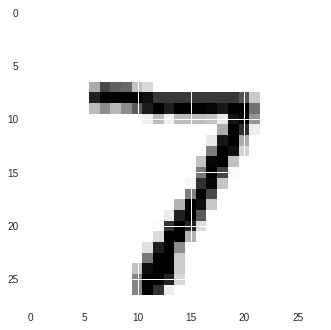

In [17]:
prediction = tf.argmax(y_pred, 1)

def predict(idx):
    image = data.test.images[idx]
    return sess.run(prediction, feed_dict={x: [image]})

idx = 0
actual = np.argmax(data.test.labels[idx])
print ("Predicted: %d, Actual: %d" % (predict(idx), actual))
plt.imshow(data.test.images[idx].reshape((28,28)), cmap=plt.cm.gray_r)

## Summary

We go through the following steps when training a CNN:
1. Initialize the filters/weights and biases with random values.
2. Perform a series of convolution, ReLU, and pooling operations to produce feature maps.
3. Flatten the feature maps and apply weights and biases
4. Pass the output from the fully connected layer through a final, softmax layer
5. Calculate loss.
6. Minimize loss via gradient descent and adjust values of filters/weights and biases. 
7. Repeat previous steps with all training images.


## Exercise: Improving the network architecture

We can improve the model's accuracy by adding more layers and filters. Rewrite the model so that its architecture matches that in the figure below. Bonus points if you use dropout. 

![CNN schematic](images/CNN_schematic.png)

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*